In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 12
plt.rcParams['xtick.labelsize'] = 24
plt.rcParams['ytick.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 24
plt.rcParams['axes.titlesize'] = 36
plt.rcParams['axes.labelsize'] = 24

In [3]:
def split_line(text):
    words = re.findall(r"[\w']+", text.lower())
    return words

with open('Jack.txt','r') as source:
    words = split_line(source.read())

In [4]:
class My_Dict:
    def __init__(self, words):
        self.dict = {}
        self.len = 0
        for word in words:
            if not word in self.dict.keys():
                self.dict[word] = self.len
                self.len += 1
        self.map = np.zeros((self.len, self.len))
        for i in range(self.len):
            self.map[i, i] = 1
            
    def OHE(self, word):
        if word in self.dict.keys():
            return self.map[self.dict[word]]
        return np.zeros(self.len)
    
    def check(self, word):
        return word in self.dict.keys()
    
    def make_set(self, words, size = 3, next_size = 0, discount = 1):
        lw = len(words)
        set_X = np.zeros((lw, self.len))
        set_Y = np.zeros((lw, self.len))
        for i in range(lw):
            elem = np.zeros(self.len)
            for j in range(size):
                if i - j > 0:
                    elem += (discount**j)*self.OHE(words[i - j - 1])
            for j in range(next_size):
                if i + 1 + j < lw:
                    elem += (discount**j)*self.OHE(words[i + 1 + j])
            set_X[i] = elem
            set_Y[i] = self.OHE(words[i])
        return set_X, set_Y
    
    def get_size(self):
        return self.len

In [5]:
class Softmax:
    
    def forward(self, x):
        self.x = x
        e_x = np.exp(x - np.max(x))
        self.value = e_x / e_x.sum(axis=0)
        return self.value
    
    def backward(self, dz, lr=0.001):
        sm = self.value
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm*self.lp
        self.ds = np.matmul(dz, self.lp2)
        return self.ds

class CrossEntropy:
    
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat + 0.0001
        return -np.sum(self.y_true*np.log(self.y_hat))
    
    def backward(self, dz, lr=0.001):
        return -dz*self.y_true/(self.y_hat)

class Dense:
    def __init__(self, in_size, out_size, rlambda = 0.0):
        self.W = np.random.normal(scale=1, size=(out_size, in_size)) * np.sqrt(2/(out_size + in_size))
        self.b = np.zeros(out_size)
        self.rlambda = rlambda
        
    def forward(self, x):
        self.x = x 
        return np.dot(self.W, x) + self.b
    
    def get_reg_loss(self):
        return 0.5 * self.rlambda * (np.linalg.norm(self.W, ord='fro') ** 2)
    
    def backward(self, dz, lr=0.001):
        self.dW = np.outer(dz, self.x)
        self.db = dz
        self.dx = np.matmul(dz, self.W) 
        if(self.rlambda != 0):
            self.dW += self.rlambda * self.W
        self.W = self.W - lr * self.dW
        self.b = self.b - lr * self.db
        return self.dx    

In [6]:
class Predict:
    def __init__(self, size):
        self.size = size
        self.d1 = Dense(size, 30)
        self.d2 = Dense(30, size)
        self.s1 = Softmax()
        self.s2 = Softmax()
        
    def forward(self, x):
        net = self.d1.forward(x)
        net = self.s1.forward(net)
        net = self.d2.forward(net)
        net = self.s2.forward(net)
        return net
    
    def backward(self, dz, lr):
        net = self.s2.backward(dz, lr)
        net = self.d2.backward(net, lr)
        net = self.s1.backward(net, lr)
        net = self.d1.backward(net, lr)
        
    def save_w(self):
        w = [self.d1.W, self.d1.b, self.d2.W, self.d2.b]
        return w
    
    def set_w(self, w):
        self.d1.W = w[0]
        self.d1.b = w[1]
        self.d2.W = w[2]
        self.d2.b = w[3]

In [7]:
def my_round(X, step): #round numbers
    mod = 10**step
    X *= mod
    X = round(X)
    X /= mod
    return X

def find_max(array, num):#find num max elems, return array of this elems and its idx
    maximums = np.zeros((2, num))
    for i in range(len(array)):
        if array[i] > np.min(maximums[0]):
            idx = np.argmin(maximums[0])
            maximums[0, idx] = array[i]
            maximums[1, idx] = i
    size = maximums.shape[1]
    for i in range(size - 1):
        for j in range(size - i - 1):
            if maximums[0, j] < maximums[0, j + 1]:
                c = maximums[0, j]
                maximums[0, j] = maximums[0, j + 1]
                maximums[0, j + 1] = c
                c = maximums[1, j]
                maximums[1, j] = maximums[1, j + 1]
                maximums[1, j + 1] = c
    return maximums

In [8]:
inf = My_Dict(words)
L_save = []
L_info = []
W_save_all = []
net_save = Predict(inf.get_size())
L_info_save = " "

In [9]:
max_iter = 2000
discount = 1

In [10]:
for size in range(2, 7):
    for next_size in range(3):  
        print("size = {}, next_size = {}".format(size, next_size))
        X, Y = inf.make_set(words, size = size, next_size = next_size, discount = discount)
        net = Predict(inf.get_size())
        loss = CrossEntropy()
        L_train = []
        W_save =[]
        #print("begin")
        for iter in range(max_iter):
            lr = 1/np.log(iter + 2)
            sh = list(range(X.shape[0]))
            np.random.shuffle(sh)
            L_acc = 0
            for i in range(X.shape[0]):
                x = X[sh[i]]
                y = Y[sh[i]]
                y_h = net.forward(x)
                L = loss.forward(y, y_h)
                L_acc += L
                dz = loss.backward(1, lr)
                dz = net.backward(dz, lr)
            L_acc /= X.shape[0]
            L_acc = my_round(L_acc, 5)
            L_train.append(L_acc)
            W_save.append(net.save_w())

        L_save.append(L_train)
        W_save_all.append(W_save)
        L_info.append([size, next_size])

size = 2, next_size = 0
size = 2, next_size = 1
size = 2, next_size = 2
size = 3, next_size = 0
size = 3, next_size = 1
size = 3, next_size = 2
size = 4, next_size = 0
size = 4, next_size = 1
size = 4, next_size = 2
size = 5, next_size = 0
size = 5, next_size = 1
size = 5, next_size = 2
size = 6, next_size = 0
size = 6, next_size = 1
size = 6, next_size = 2


D:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


BEST_NET: min loss = 0.0324 with size 2, next_size 2 (point number 2)


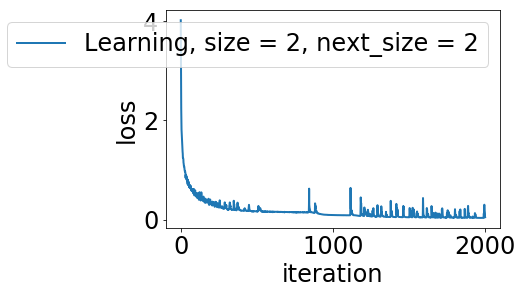

In [22]:
L_r_min = []
W_r_min = []
for i in range(len(L_save)):
    item_L = L_save[i]
    item_W = W_save_all[i]
    idx = np.argmin(item_L)
    L_r_min.append(item_L[idx])
    W_r_min.append(item_W[idx])
idx2 = np.argmin(L_r_min)
W = W_r_min[idx2]
[size, next_size] = L_info[idx2]
L_res = L_r_min[idx2]
net_save.set_w(W)
plt.plot(L_save[idx2], label='Learning, size = {}, next_size = {}'.format(size, next_size))
plt.xlabel('iteration')
plt.ylabel('loss')
plt.legend()
plt.savefig('learning.png')
print("BEST_NET: min loss = {} with size {}, next_size {} (point number {})".format(L_res, size, next_size, idx2))
X, Y = inf.make_set(words, size = size, next_size = next_size, discount = discount)

Different nets working with SIZE words before and NEXT_SIZE words after predicted one
point 0: size 2, next_size 0, value 0.08476
point 1: size 2, next_size 1, value 0.0693
point 2: size 2, next_size 2, value 0.0324
point 3: size 3, next_size 0, value 0.09048
point 4: size 3, next_size 1, value 0.04657
point 5: size 3, next_size 2, value 0.0923
point 6: size 4, next_size 0, value 0.29078
point 7: size 4, next_size 1, value 0.07953
point 8: size 4, next_size 2, value 0.09191
point 9: size 5, next_size 0, value 0.33646
point 10: size 5, next_size 1, value 0.20123
point 11: size 5, next_size 2, value 0.13121
point 12: size 6, next_size 0, value 0.40381
point 13: size 6, next_size 1, value 0.11296
point 14: size 6, next_size 2, value 0.22157


Text(0,0.5,'min loss by this net')

D:\Anaconda3\lib\site-packages\matplotlib\font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


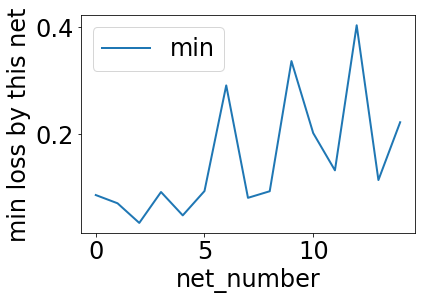

In [23]:
plt.plot(L_r_min, label='min')
plt.legend()
print("Different nets working with SIZE words before and NEXT_SIZE words after predicted one")
for i in range(len(L_info)):
    print("point {}: size {}, next_size {}, value {}".format(i, L_info[i][0], L_info[i][1], L_r_min[i]))
plt.xlabel('net_number')
plt.ylabel('min loss by this net')

In [14]:
Prediction = []
check_line = 0.1
check_net = net_save
num_variants = 5
for i in range(len(X)):
    variants = []
    answer = find_max(check_net.forward(X[i]), num_variants)
    for i in range(5):
        check = answer[:, i]
        if i == 0:
            for k, v in inf.dict.items():
                if v == check[1]:
                    temp = {}
                    temp[k] = str(100*my_round(check[0],2)) + "%"
                    variants.append(temp)
        else: 
            if check[0] > check_line:
                for k, v in inf.dict.items():
                    if v == check[1]:
                        temp = {}
                        temp[k] = str(100*my_round(check[0],2)) + "%"
                        variants.append(temp)
    Prediction.append(variants)
print(L_info_save)
for i in range(len(Prediction)):
    print(Prediction[i])

 
[{'вот': '98.0%'}]
[{'дом': '74.0%'}]
[{'который': '99.0%'}]
[{'построил': '97.0%'}]
[{'джек': '89.0%'}]
[{'а': '95.0%'}]
[{'это': '99.0%'}]
[{'пшеница': '96.0%'}]
[{'которая': '100.0%'}]
[{'в': '100.0%'}]
[{'тёмном': '100.0%'}]
[{'чулане': '100.0%'}]
[{'хранится': '100.0%'}]
[{'в': '100.0%'}]
[{'доме': '100.0%'}]
[{'который': '99.0%'}]
[{'построил': '97.0%'}]
[{'джек': '89.0%'}]
[{'а': '95.0%'}]
[{'это': '99.0%'}]
[{'весёлая': '97.0%'}]
[{'птица': '87.0%'}]
[{'синица': '95.0%'}]
[{'которая': '100.0%'}]
[{'часто': '100.0%'}]
[{'ворует': '100.0%'}]
[{'пшеницу': '100.0%'}]
[{'которая': '100.0%'}]
[{'в': '100.0%'}]
[{'тёмном': '100.0%'}]
[{'чулане': '100.0%'}]
[{'хранится': '100.0%'}]
[{'в': '100.0%'}]
[{'доме': '100.0%'}]
[{'который': '99.0%'}]
[{'построил': '96.0%'}]
[{'джек': '88.0%'}]
[{'джек': '89.0%'}]
[{'кот': '97.0%'}]
[{'который': '99.0%'}]
[{'пугает': '99.0%'}]
[{'и': '100.0%'}]
[{'ловит': '100.0%'}]
[{'синицу': '99.0%'}]
[{'которая': '100.0%'}]
[{'часто': '100.0%'}]
[{'ворует

In [15]:
before_net = Predict(inf.get_size())
before_net.set_w(W_r_min[0])

In [16]:
X_before, Y_before = inf.make_set(words, size = 2, next_size = 0, discount = discount)
Prediction = []
check_line = 0.1
check_net = before_net
num_variants = 5
for i in range(len(X_before)):
    variants = []
    answer = find_max(check_net.forward(X_before[i]), num_variants)
    for i in range(5):
        check = answer[:, i]
        if i == 0:
            for k, v in inf.dict.items():
                if v == check[1]:
                    temp = {}
                    temp[k] = str(100*my_round(check[0],2)) + "%"
                    variants.append(temp)
        else: 
            if check[0] > check_line:
                for k, v in inf.dict.items():
                    if v == check[1]:
                        temp = {}
                        temp[k] = str(100*my_round(check[0],2)) + "%"
                        variants.append(temp)
    Prediction.append(variants)
print("best prediction based only on previous words")
for i in range(len(Prediction)):
    print(Prediction[i])

best prediction based only on previous words
[{'вот': '96.0%'}]
[{'дом': '88.0%'}]
[{'который': '100.0%'}]
[{'построил': '99.0%'}]
[{'джек': '99.0%'}]
[{'а': '56.00000000000001%'}, {'вот': '44.0%'}]
[{'это': '99.0%'}]
[{'корова': '20.0%'}, {'старушка': '20.0%'}, {'ленивый': '20.0%'}, {'весёлая': '19.0%'}, {'пшеница': '19.0%'}]
[{'которая': '100.0%'}]
[{'в': '99.0%'}]
[{'тёмном': '98.0%'}]
[{'чулане': '100.0%'}]
[{'хранится': '100.0%'}]
[{'в': '100.0%'}]
[{'доме': '99.0%'}]
[{'который': '100.0%'}]
[{'построил': '99.0%'}]
[{'джек': '99.0%'}]
[{'а': '56.00000000000001%'}, {'вот': '44.0%'}]
[{'это': '99.0%'}]
[{'корова': '20.0%'}, {'старушка': '20.0%'}, {'ленивый': '20.0%'}, {'весёлая': '19.0%'}, {'пшеница': '19.0%'}]
[{'птица': '95.0%'}]
[{'синица': '96.0%'}]
[{'которая': '100.0%'}]
[{'часто': '98.0%'}]
[{'ворует': '100.0%'}]
[{'пшеницу': '100.0%'}]
[{'которая': '100.0%'}]
[{'в': '100.0%'}]
[{'тёмном': '98.0%'}]
[{'чулане': '100.0%'}]
[{'хранится': '100.0%'}]
[{'в': '100.0%'}]
[{'доме': '

## Можем видеть, что погрешность у сетей, подсматривающих на следующее слово меньше, чем у тех, у которых next_size = 0. 
## Это потому, что текст содержит повторяющиеся куски, после которых могут стоят разные слова, и у сети которая смотрит лишь на предыдущие слова, недостаточно информации для точного восстановления текста. 
## Когда сеть смотрит на много предыдущих слов, погрешность также растет. Такой сети необходимо больше времени на обучение. Для нее различие контекста в одно слово становится менее значительным